In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import wrangle
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt
import pydataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error

In [2]:
df = pydataset.data('swiss')

In [3]:
df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [5]:
df=df.rename(columns={"Infant.Mortality":"Infant_Mortality"})

In [6]:
def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames.
    return train, validate, test DataFrames.
    '''
    
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123)
    return train, validate, test

In [7]:
train, validate, test = split_data(df)

In [8]:
df=train

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, Rolle to Avenches
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         25 non-null     float64
 1   Agriculture       25 non-null     float64
 2   Examination       25 non-null     int64  
 3   Education         25 non-null     int64  
 4   Catholic          25 non-null     float64
 5   Infant_Mortality  25 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 1.4+ KB


In [10]:
train_scaled = train.copy()

In [11]:
validate_scaled = validate.copy()

In [12]:
test_scaled = test.copy()

In [13]:
train_scaled.columns

Index(['Fertility', 'Agriculture', 'Examination', 'Education', 'Catholic',
       'Infant_Mortality'],
      dtype='object')

In [14]:
# make, fit, use:
columns_to_scale = ['Agriculture', 'Examination', 'Education', 'Catholic','Infant_Mortality']  
# make the object, put it into the variable scaler
scaler = MinMaxScaler()
# fit the object to my data:
train_scaled[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])

In [15]:
def visualize_scaler(scaler, df, columns_to_scale):
    fig, axs = plt.subplots(len(columns_to_scale), 2, figsize=(30, 20))
    df_scaled = df.copy()
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    for (ax1, ax2), col in zip(axs, columns_to_scale):
        ax1.hist(df[col])
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col])
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()
#    return fig, axs

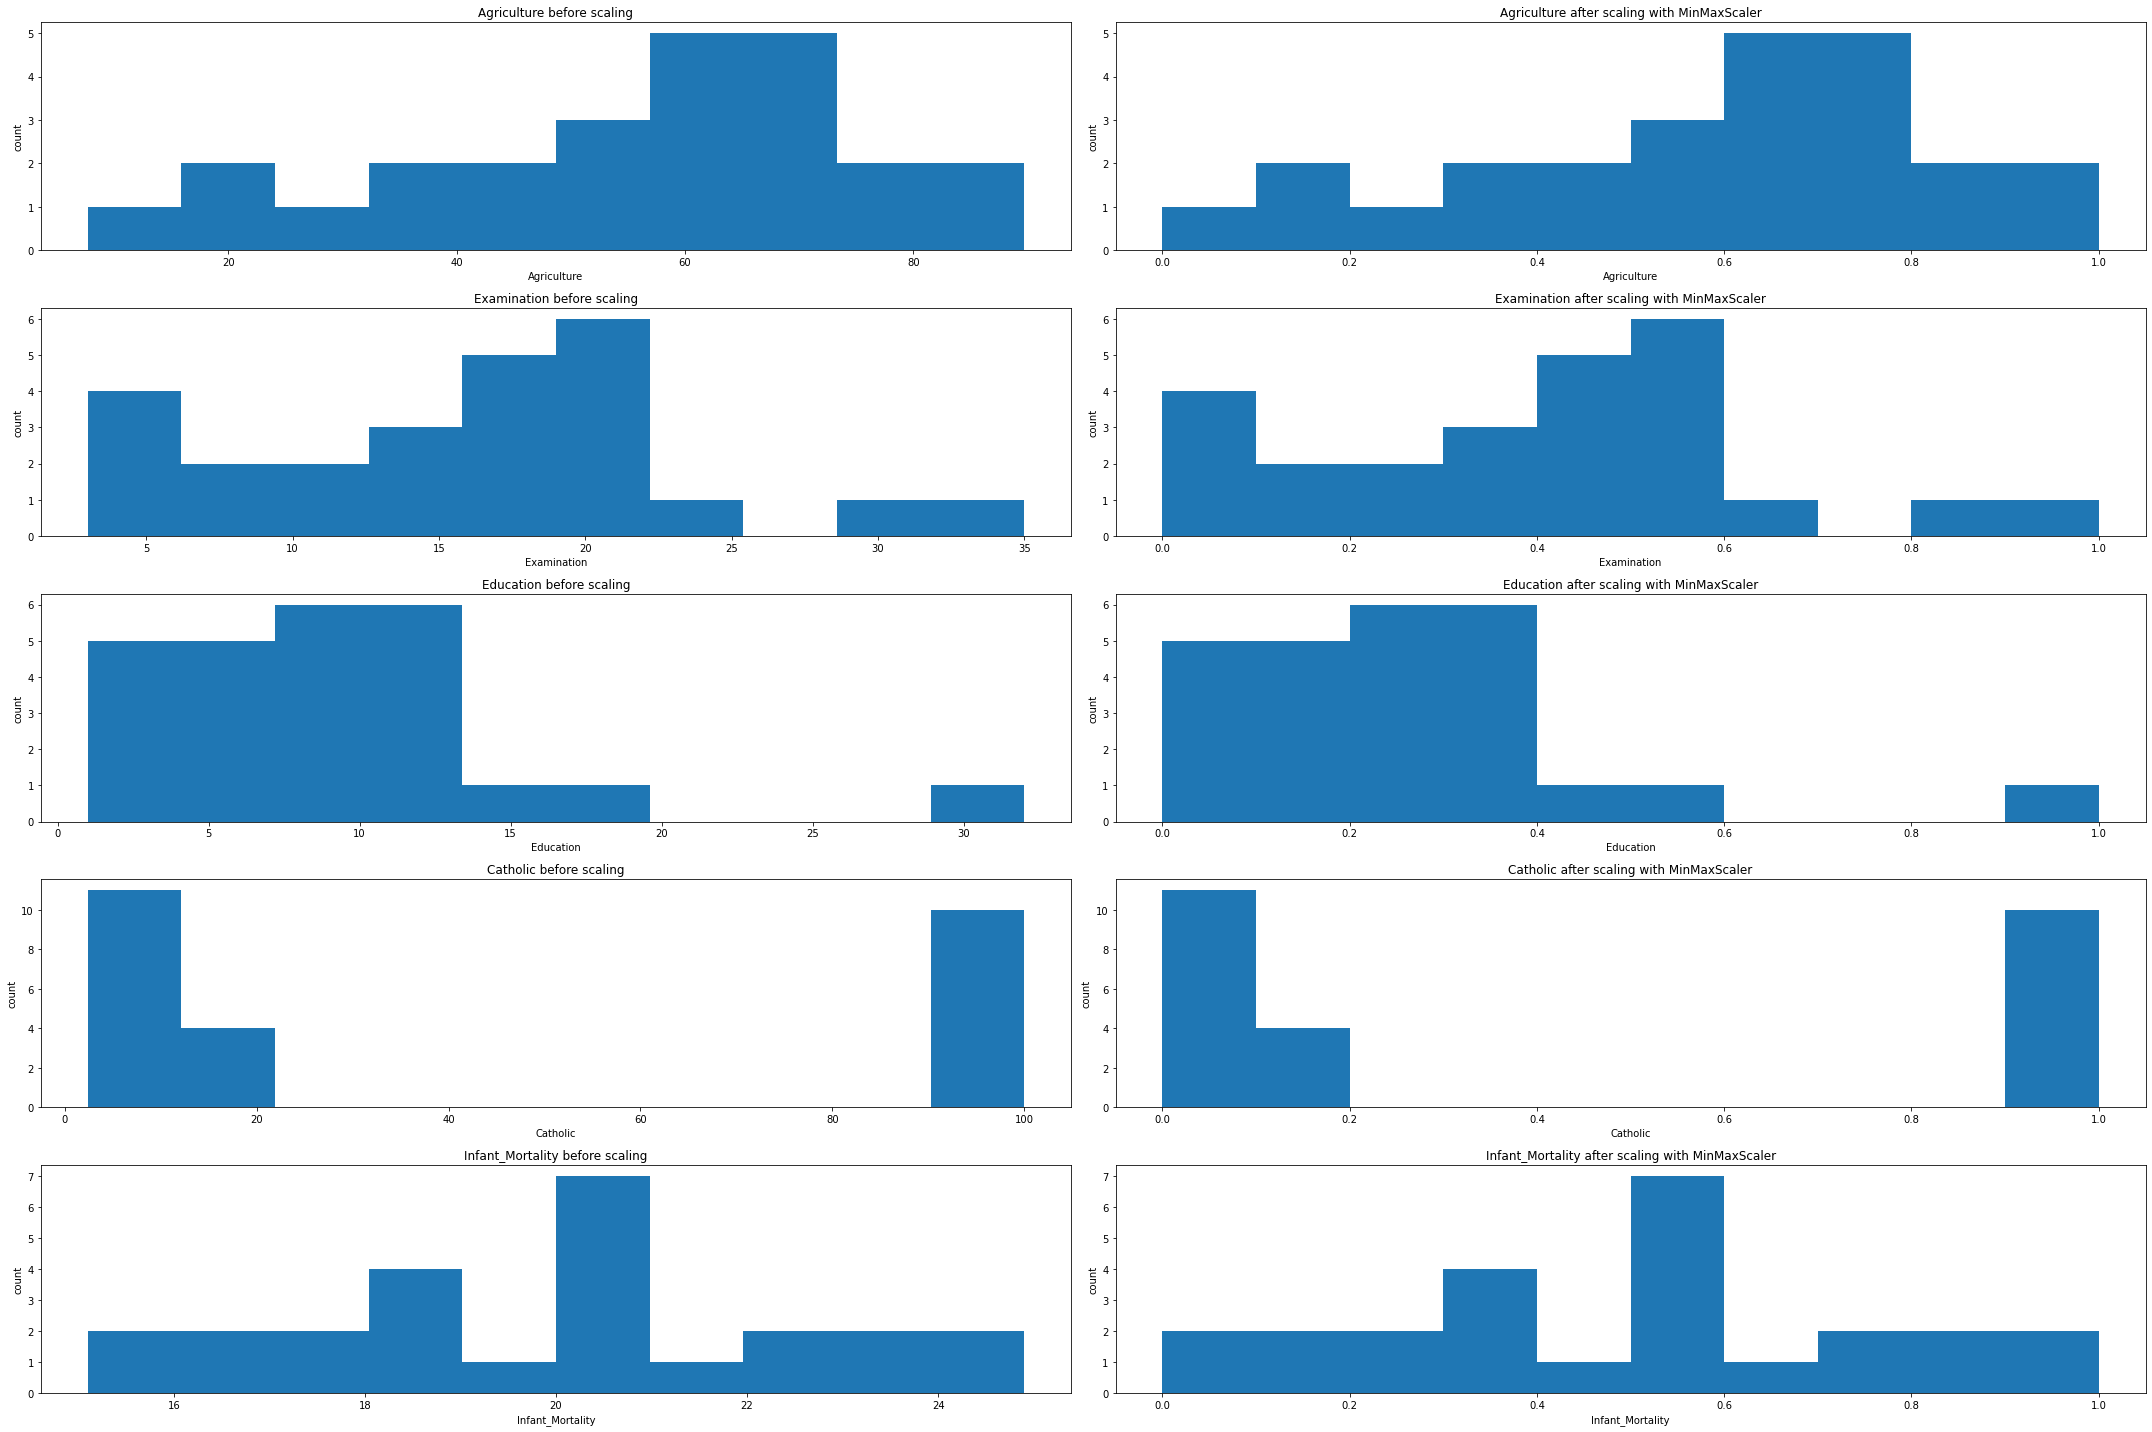

In [16]:
# MinMaxScaler Applied
visualize_scaler(scaler=MinMaxScaler(), 
                 df=train, 
                 columns_to_scale=columns_to_scale)

In [17]:
X_train=train_scaled.drop(columns=['Fertility'])
y_train=train_scaled.Fertility

In [18]:
X_validate=validate_scaled.drop(columns=['Fertility'])
y_validate=validate_scaled.Fertility

In [19]:
X_test=test_scaled.drop(columns=['Fertility'])
y_test=test_scaled.Fertility

In [20]:
predictions = pd.DataFrame({
    'actual': validate.Fertility
}) 

In [21]:
predictions.head()

,actual
Moudon,65.0
Echallens,68.3
Moutier,85.8
Morges,65.5
Sierre,92.2


In [22]:
# X must be 2-d
X_train = train[['Agriculture']]
# y can be 1-d
y_train = train.Fertility

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['Agriculture']]
predictions['simple_lm'] = lm.predict(X_validate)

In [23]:
predictions.head()

,actual,simple_lm
Moudon,65.0,71.528282
Echallens,68.3,72.935217
Moutier,85.8,70.032911
Morges,65.5,71.906144
Sierre,92.2,73.899972


In [24]:
lm.coef_, lm.intercept_

(array([0.08039626]), 67.09844784624015)

In [25]:
print('Fertility = {:.2f} * Agriculture + {:.2f}'.format(lm.coef_[0], lm.intercept_))

Fertility = 0.08 * Agriculture + 67.10


In [26]:
# Fertility = 0.08 * Agriculture + 67.10
print(f'For every 1 point increase in Agriculture, we predict a {lm.coef_[0]:.2f} point increase in Fertility')

For every 1 point increase in Agriculture, we predict a 0.08 point increase in Fertility


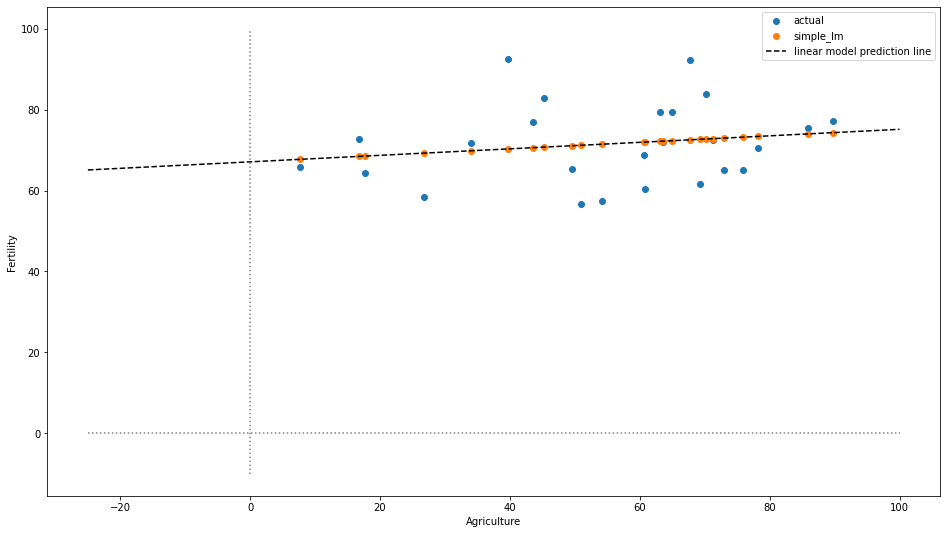

In [27]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.Agriculture, train.Fertility, label='actual')
plt.scatter(train.Agriculture, lm.predict(train[['Agriculture']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Agriculture')
plt.ylabel('Fertility')
plt.legend()

In [28]:
Agriculture = np.arange(75, 85)
Fertility = lm.predict(Agriculture.reshape(-1, 1))
pd.DataFrame(dict(Agriculture=Agriculture, predicted_fertility=Fertility))

,Agriculture,predicted_fertility
0,75,73.128168
1,76,73.208564
2,77,73.288960
3,78,73.369356
4,79,73.449753
5,80,73.530149
6,81,73.610545
7,82,73.690941
8,83,73.771338
9,84,73.851734


In [29]:
# X must be 2-d
X_train = train[[ 'Examination']]
# y can be 1-d
y_train = train.Fertility

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['Examination']]
predictions['simple_lm'] = lm.predict(X_validate)

In [30]:
predictions.head()

,actual,simple_lm
Moudon,65.0,72.792474
Echallens,68.3,70.061009
Moutier,85.8,74.158206
Morges,65.5,67.329544
Sierre,92.2,80.304002


In [31]:
lm.coef_, lm.intercept_

(array([-0.68286618]), 82.35260032191819)

In [32]:
print('Fertility = {:.2f} * Examination + {:.2f}'.format(lm.coef_[0], lm.intercept_))

Fertility = -0.68 * Examination + 82.35


In [33]:
# Fertility = -0.68 * Examination  + 82.35
print(f'For every 1 point increase in Examination, we predict a {lm.coef_[0]:.2f} point increase in Fertility')

For every 1 point increase in Examination, we predict a -0.68 point increase in Fertility


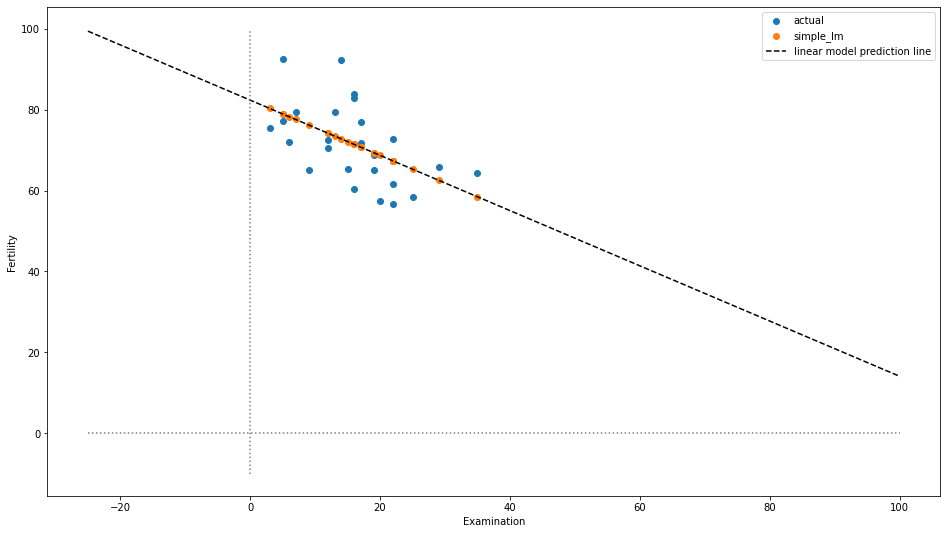

In [34]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.Examination, train.Fertility, label='actual')
plt.scatter(train.Examination, lm.predict(train[['Examination']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Examination')
plt.ylabel('Fertility')
plt.legend()

In [35]:
Examination = np.arange(82, 87)
Fertility = lm.predict(Examination.reshape(-1, 1))
pd.DataFrame(dict(Examination=Examination, predicted_fertility=Fertility))

,Examination,predicted_fertility
0,82,26.357573
1,83,25.674707
2,84,24.991841
3,85,24.308975
4,86,23.626109


In [36]:
# X must be 2-d
X_train = train[['Education']]
# y can be 1-d
y_train = train.Fertility

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['Education']]
predictions['simple_lm'] = lm.predict(X_validate)

In [37]:
predictions.head()

,actual,simple_lm
Moudon,65.0,74.126028
Echallens,68.3,74.538453
Moutier,85.8,72.476329
Morges,65.5,71.239054
Sierre,92.2,74.126028


In [38]:
lm.coef_, lm.intercept_

(array([-0.41242488]), 75.36330289549676)

In [39]:
print('Fertility = {:.2f} * Education + {:.2f}'.format(lm.coef_[0], lm.intercept_))

Fertility = -0.41 * Education + 75.36


In [40]:
# Fertility = -0.41* Education  + 75.36
print(f'For every 1 point increase in Education, we predict a {lm.coef_[0]:.2f} point increase in Fertility')

For every 1 point increase in Education, we predict a -0.41 point increase in Fertility


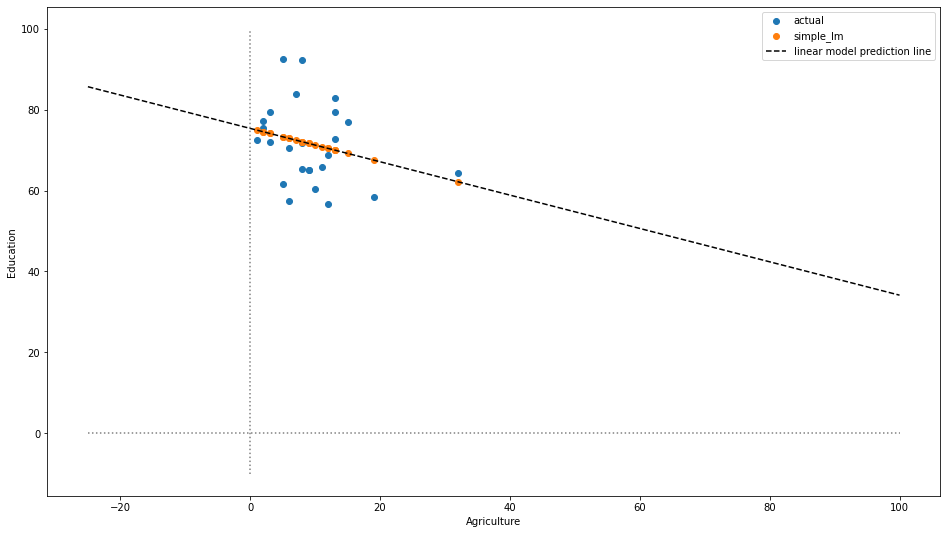

In [41]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.Education, train.Fertility, label='actual')
plt.scatter(train.Education, lm.predict(train[['Education']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Agriculture')
plt.ylabel('Education')
plt.legend()

In [42]:
Education = np.arange(75, 87)
Fertility = lm.predict(Education.reshape(-1, 1))
pd.DataFrame(dict(Education=Education, predicted_fertility=Fertility))


,Education,predicted_fertility
0,75,44.431437
1,76,44.019012
2,77,43.606587
3,78,43.194162
4,79,42.781737
5,80,42.369312
6,81,41.956888
7,82,41.544463
8,83,41.132038
9,84,40.719613


In [43]:
# X must be 2-d
X_train = train[['Catholic']]
# y can be 1-d
y_train = train.Fertility

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['Catholic']]
predictions['simple_lm'] = lm.predict(X_validate)

In [44]:
predictions.head()

,actual,simple_lm
Moudon,65.0,65.837047
Echallens,68.3,68.722801
Moutier,85.8,70.126087
Morges,65.5,65.941157
Sierre,92.2,79.758462


In [45]:
lm.coef_, lm.intercept_

(array([0.14663382]), 65.17426247751776)

In [46]:
print('Fertility = {:.2f} * Catholic + {:.2f}'.format(lm.coef_[0], lm.intercept_))

Fertility = 0.15 * Catholic + 65.17


In [47]:
# Fertility = 0.15 * Catholic  + 65.17
print(f'For every 1 point increase in Catholic, we predict a {lm.coef_[0]:.2f} point increase in Fertility')

For every 1 point increase in Catholic, we predict a 0.15 point increase in Fertility


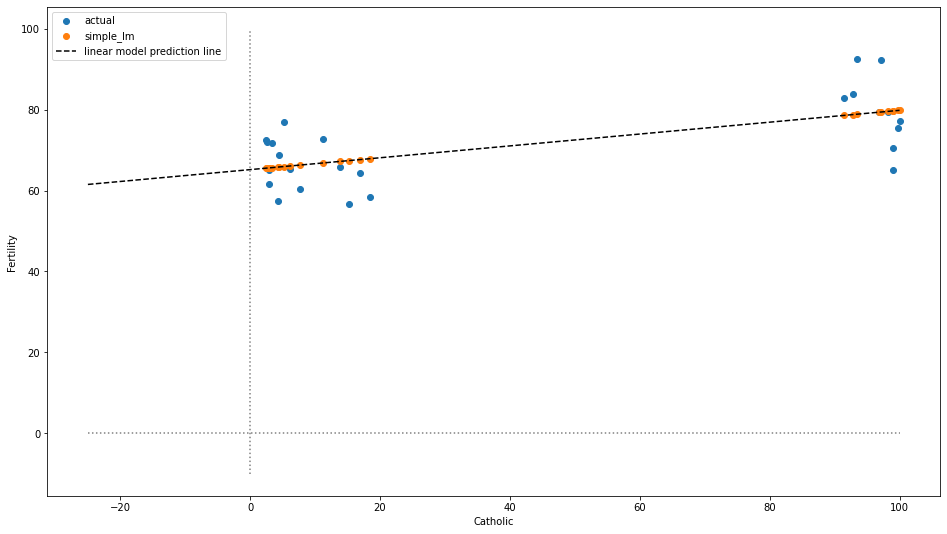

In [48]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.Catholic, train.Fertility, label='actual')
plt.scatter(train.Catholic, lm.predict(train[['Catholic']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Catholic')
plt.ylabel('Fertility')
plt.legend()

In [49]:
Catholic = np.arange(75, 87)
Fertility = lm.predict(Catholic.reshape(-1, 1))
pd.DataFrame(dict(Catholic=Catholic, predicted_fertility=Fertility))

,Catholic,predicted_fertility
0,75,76.171799
1,76,76.318433
2,77,76.465066
3,78,76.611700
4,79,76.758334
5,80,76.904968
6,81,77.051602
7,82,77.198236
8,83,77.344869
9,84,77.491503


In [50]:
# X must be 2-d
X_train = train[['Infant_Mortality']]
# y can be 1-d
y_train = train.Fertility

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['Infant_Mortality']]
predictions['simple_lm'] = lm.predict(X_validate)

In [51]:
predictions.head()

,actual,simple_lm
Moudon,65.0,75.758117
Echallens,68.3,73.744388
Moutier,85.8,72.234092
Morges,65.5,68.374447
Sierre,92.2,65.521665


In [52]:
lm.coef_, lm.intercept_

(array([1.67810674]), 38.1685255904402)

In [53]:
print('Fertility = {:.2f} * Infant_Mortality + {:.2f}'.format(lm.coef_[0], lm.intercept_))

Fertility = 1.68 * Infant_Mortality + 38.17


In [54]:
# Fertility = 1.68* Infant_Mortality  + 38.17
print(f'For every 1 point increase in Infant_Mortality, we predict a {lm.coef_[0]:.2f} point increase in Fertility')

For every 1 point increase in Infant_Mortality, we predict a 1.68 point increase in Fertility


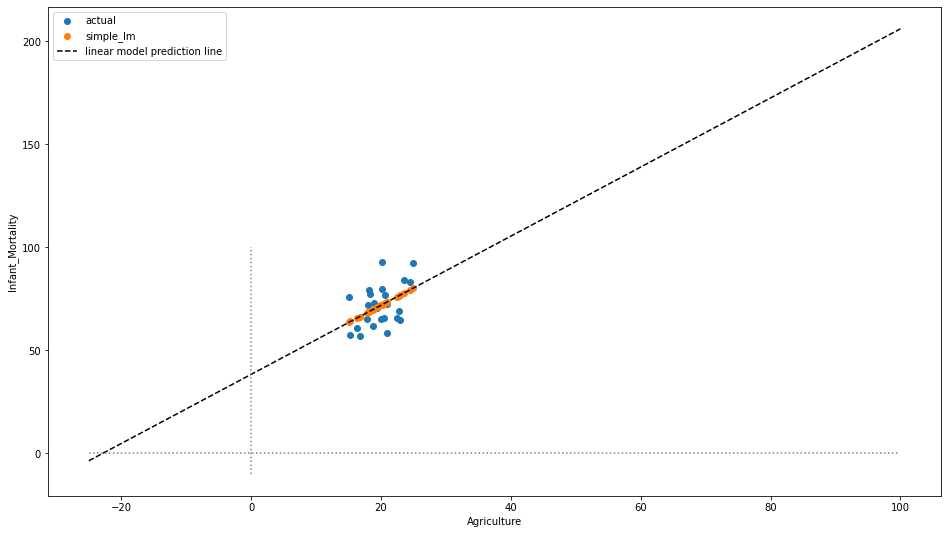

In [55]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.Infant_Mortality, train.Fertility, label='actual')
plt.scatter(train.Infant_Mortality, lm.predict(train[['Infant_Mortality']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Infant_Mortality')
plt.ylabel('Fertility')
plt.legend()

In [56]:
Infant_Mortality = np.arange(75, 87)
Fertility = lm.predict(Infant_Mortality.reshape(-1, 1))
pd.DataFrame(dict(Infant_Mortality=Infant_Mortality, predicted_fertility=Fertility))

,Infant_Mortality,predicted_fertility
0,75,164.026531
1,76,165.704638
2,77,167.382745
3,78,169.060851
4,79,170.738958
5,80,172.417065
6,81,174.095171
7,82,175.773278
8,83,177.451385
9,84,179.129492


In [57]:
X_train = train.drop(columns='Fertility')
y_train = train.Fertility
X_validate = validate.drop(columns='Fertility')

lm = LinearRegression()
k = 2

# 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train, y_train)
print('selected top 2 features:', X_train.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train)

selected top 2 features: Index(['Examination', 'Infant_Mortality'], dtype='object')


In [58]:
X_train.shape

(25, 5)

In [59]:
X_train_rfe.shape

(25, 2)

In [60]:
# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_validate_rfe = rfe.transform(X_validate)
predictions['multiple_rfe'] = lm.predict(X_validate_rfe)

predictions.head()

,actual,simple_lm,multiple_rfe
Moudon,65.0,75.758117,79.180470
Echallens,68.3,73.744388,72.719716
Moutier,85.8,72.234092,75.987317
Morges,65.5,68.374447,61.500793
Sierre,92.2,65.521665,74.584142


In [61]:
X_train.columns[rfe.support_]

Index(['Examination', 'Infant_Mortality'], dtype='object')

In [62]:
lm.coef_, lm.intercept_

(array([-0.90146286,  2.37908502]), 38.50944506277681)

In [63]:
print(f'Fertility = {lm.coef_[0]:.2f} x Examination + {lm.coef_[1]:.2f} x Infant_Mortality + {lm.intercept_:.2f}')

Fertility = -0.90 x Examination + 2.38 x Infant_Mortality + 38.51


In [64]:
X = pd.DataFrame({
    'Examination': [80, 81, 82, 83, 84, 85, 85, 85, 85, 85, 85],
    'Infant_Mortality': [80, 80, 80, 80, 80, 80, 81, 82, 83, 84, 85]
})

X['Fertility'] = lm.predict(X)
X

,Examination,Infant_Mortality,Fertility
0,80,80,156.719218
1,81,80,155.817755
2,82,80,154.916293
3,83,80,154.014830
4,84,80,153.113367
5,85,80,152.211904
6,85,81,154.590989
7,85,82,156.970074
8,85,83,159.349159
9,85,84,161.728244


In [65]:
from sklearn.preprocessing import PolynomialFeatures

X_train = train[['Agriculture', 'Examination', 'Education', 'Catholic','Infant_Mortality']]
X_validate = validate[['Agriculture', 'Examination', 'Education', 'Catholic','Infant_Mortality']]
y_train = train.Fertility
y_validate = validate.Fertility

# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
X_train_poly.head()

,Agriculture,Examination,Education,Catholic,Infant_Mortality,Agriculture^2,Agriculture Examination,Agriculture Education,Agriculture Catholic,Agriculture Infant_Mortality,Examination^2,Examination Education,Examination Catholic,Examination Infant_Mortality,Education^2,Education Catholic,Education Infant_Mortality,Catholic^2,Catholic Infant_Mortality,Infant_Mortality^2
Rolle,60.8,16.0,10.0,7.72,16.3,3696.64,972.8,608.0,469.376,991.04,256.0,160.0,123.52,260.8,100.0,77.20,163.0,59.5984,125.836,265.69
Lavaux,73.0,19.0,9.0,2.84,20.0,5329.00,1387.0,657.0,207.320,1460.00,361.0,171.0,53.96,380.0,81.0,25.56,180.0,8.0656,56.800,400.00
Nyone,50.9,22.0,12.0,15.14,16.7,2590.81,1119.8,610.8,770.626,850.03,484.0,264.0,333.08,367.4,144.0,181.68,200.4,229.2196,252.838,278.89
Conthey,85.9,3.0,2.0,99.71,15.1,7378.81,257.7,171.8,8565.089,1297.09,9.0,6.0,299.13,45.3,4.0,199.42,30.2,9942.0841,1505.621,228.01
Yverdon,49.5,15.0,8.0,6.10,22.5,2450.25,742.5,396.0,301.950,1113.75,225.0,120.0,91.50,337.5,64.0,48.80,180.0,37.2100,137.250,506.25


In [66]:
'Agriculture', 'Examination', 'Education', 'Catholic','Infant_Mortality'

('Agriculture', 'Examination', 'Education', 'Catholic', 'Infant_Mortality')

In [67]:
# 2. Use the features
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial degree 2'] = lm.predict(X_validate_poly)

In [68]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2
Moudon,65.0,75.758117,79.180470,70.440827
Echallens,68.3,73.744388,72.719716,56.529804
Moutier,85.8,72.234092,75.987317,52.966604
Morges,65.5,68.374447,61.500793,56.233434
Sierre,92.2,65.521665,74.584142,73.448374


In [69]:
feature_names = poly.get_feature_names(X_train.columns)
pd.Series(lm.coef_, index=feature_names).sort_values()

Infant_Mortality               -21.547623
Examination                     -6.656864
Agriculture                     -2.383414
Catholic                        -1.052150
Education Infant_Mortality      -0.294139
Examination Education           -0.186597
Agriculture Education           -0.037050
Education Catholic              -0.021871
Agriculture Catholic            -0.005122
Catholic Infant_Mortality       -0.002921
Agriculture^2                    0.008696
Catholic^2                       0.014627
Examination Catholic             0.016078
Agriculture Examination          0.024626
Agriculture Infant_Mortality     0.063376
Education^2                      0.086182
Examination^2                    0.090223
Examination Infant_Mortality     0.129974
Infant_Mortality^2               0.493032
Education                       10.548768
dtype: float64

In [70]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial only interaction'] = lm.predict(X_validate_poly)

pd.Series(lm.coef_, index=poly.get_feature_names(X_train.columns)).sort_values()

Infant_Mortality               -13.914894
Examination                     -7.688899
Agriculture                     -2.957106
Catholic                        -0.132381
Examination Education           -0.055047
Agriculture Education           -0.025265
Examination Catholic            -0.016971
Agriculture Catholic            -0.001199
Agriculture Examination          0.006910
Education Catholic               0.009351
Catholic Infant_Mortality        0.021658
Education Infant_Mortality       0.046714
Agriculture Infant_Mortality     0.146670
Examination Infant_Mortality     0.371089
Education                        1.088885
dtype: float64

In [71]:
X_train.head()

,Agriculture,Examination,Education,Catholic,Infant_Mortality
Rolle,60.8,16,10,7.72,16.3
Lavaux,73.0,19,9,2.84,20.0
Nyone,50.9,22,12,15.14,16.7
Conthey,85.9,3,2,99.71,15.1
Yverdon,49.5,15,8,6.10,22.5


In [72]:
y_train.head()

Rolle      60.5
Lavaux     65.1
Nyone      56.6
Conthey    75.5
Yverdon    65.4
Name: Fertility, dtype: float64

In [73]:
X_validate.head()

,Agriculture,Examination,Education,Catholic,Infant_Mortality
Moudon,55.1,14,3,4.52,22.4
Echallens,72.6,18,2,24.20,21.2
Moutier,36.5,12,7,33.77,20.3
Morges,59.8,22,10,5.23,18.0
Sierre,84.6,3,3,99.46,16.3


In [74]:
y_validate.head()

Moudon       65.0
Echallens    68.3
Moutier      85.8
Morges       65.5
Sierre       92.2
Name: Fertility, dtype: float64

In [75]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction
Moudon,65.0,75.758117,79.180470,70.440827,68.342976
Echallens,68.3,73.744388,72.719716,56.529804,73.289903
Moutier,85.8,72.234092,75.987317,52.966604,74.459845
Morges,65.5,68.374447,61.500793,56.233434,56.666819
Sierre,92.2,65.521665,74.584142,73.448374,77.953231


In [76]:
predictions['baseline']=y_train.mean()

In [77]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,baseline
Moudon,65.0,75.758117,79.180470,70.440827,68.342976,71.536
Echallens,68.3,73.744388,72.719716,56.529804,73.289903,71.536
Moutier,85.8,72.234092,75.987317,52.966604,74.459845,71.536
Morges,65.5,68.374447,61.500793,56.233434,56.666819,71.536
Sierre,92.2,65.521665,74.584142,73.448374,77.953231,71.536


In [78]:
from sklearn.linear_model import LassoLars

In [79]:
# create the model object
lars = LassoLars(alpha=0)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

In [80]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

Examination        -0.796120
Agriculture        -0.167471
Education          -0.160315
Catholic            0.086873
Infant_Mortality    1.949335
dtype: float64

In [81]:
# create the model object
lars = LassoLars(alpha=0.5)

# fit the model to our training data= 
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

In [82]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

Examination        -0.209033
Agriculture         0.000000
Education           0.000000
Catholic            0.064415
Infant_Mortality    0.790440
dtype: float64

In [83]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['lasso_lars'] = X_validate_pred_lars

In [84]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

Agriculture         0.000000
Examination         0.000000
Education           0.000000
Infant_Mortality    0.000000
Catholic            0.032551
dtype: float64

In [85]:
lars.intercept_

70.12378080549193

In [86]:
# create the model object
lars_high_alpha = LassoLars(alpha=2)

# fit the model to our training data
lars_high_alpha.fit(X_train, y_train)

# predict validate
X_validate_pred_lars_high_alpha = lars.predict(X_validate)

In [87]:
pd.Series(lars_high_alpha.coef_, index=X_train.columns).sort_values()

Agriculture         0.0
Examination         0.0
Education           0.0
Catholic            0.0
Infant_Mortality    0.0
dtype: float64

In [88]:
lars_high_alpha.intercept_

71.536

In [89]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,baseline,lasso_lars
Moudon,65.0,75.758117,79.180470,70.440827,68.342976,71.536,70.270910
Echallens,68.3,73.744388,72.719716,56.529804,73.289903,71.536,70.911508
Moutier,85.8,72.234092,75.987317,52.966604,74.459845,71.536,71.223018
Morges,65.5,68.374447,61.500793,56.233434,56.666819,71.536,70.294021
Sierre,92.2,65.521665,74.584142,73.448374,77.953231,71.536,73.361275


In [90]:
from sklearn.linear_model import TweedieRegressor

# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data
glm.fit(X_train, y_train)

# predict validate
X_validate_predict_glm = glm.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['glm'] = X_validate_predict_glm

In [91]:
pd.Series(glm.coef_, index=X_train.columns).sort_values()

Examination        -0.011642
Agriculture        -0.002267
Education          -0.001696
Catholic            0.001138
Infant_Mortality    0.027350
dtype: float64

In [92]:
glm.intercept_

3.9950413580467807

In [93]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,baseline,lasso_lars,glm
Moudon,65.0,75.758117,79.180470,70.440827,68.342976,71.536,70.270910,75.176028
Echallens,68.3,73.744388,72.719716,56.529804,73.289903,71.536,70.911508,68.365149
Moutier,85.8,72.234092,75.987317,52.966604,74.459845,71.536,71.223018,77.817211
Morges,65.5,68.374447,61.500793,56.233434,56.666819,71.536,70.294021,59.420292
Sierre,92.2,65.521665,74.584142,73.448374,77.953231,71.536,73.361275,75.356502


In [94]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).sort_values()

actual                           0.000000
glm                            148.117659
multiple_rfe                   152.658638
lasso_lars                     212.689055
baseline                       218.478263
simple_lm                      226.385260
polynomial only interaction    278.289035
polynomial degree 2            710.620538
dtype: float64

In [95]:
# re-create our polynomial model
X_train = train[['Agriculture', 'Examination', 'Education', 'Catholic','Infant_Mortality']]
y_train = train.Fertility

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)

lm = LinearRegression()
lm.fit(X_train_poly, y_train)

LinearRegression()

In [96]:
# any transformations applied to your training data must be applied to the test as well

X_test = test[['Agriculture', 'Examination', 'Education', 'Catholic','Infant_Mortality']]
X_test_poly = poly.transform(X_test)

test_predictions = lm.predict(X_test_poly)
test_actual = test.Fertility

In [97]:
mean_squared_error(test_actual, test_predictions)

3572.0142190104852